In [1]:
import random as r
import numpy as np
import pandas as pd
import seaborn as sns

# Matplotlib Imports
import matplotlib  
import matplotlib.pyplot as plt
matplotlib.use(u'nbAgg')
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, confusion_matrix
from sklearn import metrics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
columns = ['Timestamp(ms)', 'Current(uA)']

df1 = pd.read_csv("ic/ALL_BLOCKS_ON.csv", usecols=columns)
df2 = pd.read_csv("ic/I2C_OFF_UART0_ON.csv", usecols=columns)
df3 = pd.read_csv("ic/Normal operation.csv", usecols=columns)
df4 = pd.read_csv("ic/PIT_OFF_I2C_ON_UART0_ON.csv", usecols=columns)
df5 = pd.read_csv("ic/UART0_OFF_I2C_ON.csv", usecols=columns)

In [3]:
class_names = ['1', '2', '3', '4', '5']

merged_df = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)

merged_df['Class'] = pd.Series(dtype='str')

In [4]:
index = 0
for i, df in enumerate([df1, df2, df3, df4, df5]):
    # Determine the start and end index for this dataset
    start = index
    end = index + len(df)

    merged_df.loc[start:end, 'Class'] = class_names[i]

    # Increment the index counter
    index = end + 1

In [5]:
merged_df = merged_df.rename(columns={'Timestamp(ms)': 'Timestamp', 'Current(uA)': 'Current'})

merged_df

,Timestamp,Current,Class
0,53119.04,126754.914,1
1,53119.05,126754.914,1
2,53119.06,125226.094,1
3,53119.07,127519.430,1
4,53119.08,127519.430,1
...,...,...,...
3500340,46806.99,130578.195,5
3500341,46807.00,134403.234,5
3500342,46807.01,130578.195,5
3500343,46807.02,132108.000,5


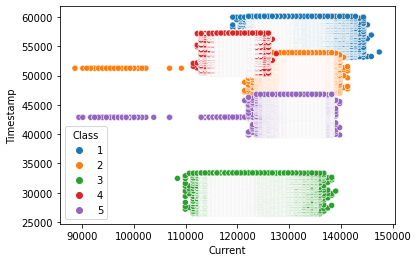

In [6]:
sns.scatterplot(x="Current", y="Timestamp", hue="Class", data=merged_df)
plt.show()

In [7]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

In [8]:
merged_df = normalize(merged_df)
X = merged_df.iloc[:, 0:2]
y = merged_df.Class

In [9]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

print("Before oversampling",  X.shape, y.shape)
        
oversample = RandomOverSampler(sampling_strategy="not majority")  #SMOTE()
        
X, y = oversample.fit_resample(X, y)
        
print("After oversampling",  X.shape, y.shape)

Before oversampling (3500345, 2) (3500345,)
After oversampling (3500350, 2) (3500350,)


In [10]:
class Model:
    def __init_subclass__(cls) -> None:
        pass

    def decisionTree(self, X_train, y_train, X_test, y_test):
        # training a DescisionTreeClassifier
        print('DescisionTreeClassifier')

        # dtree_model = DecisionTreeClassifier(criterion="entropy", max_depth=3).fit(X_train, y_train)
        dtree_model = DecisionTreeClassifier(criterion="gini", max_depth=3).fit(X_train, y_train)
        dtree_predictions = dtree_model.predict(X_test)

        # Metrics evaluation
        accuracy = metrics.accuracy_score(y_test, dtree_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, dtree_predictions,
                                                                               average='weighted')
        cm = confusion_matrix(y_test, dtree_predictions)
      

        print("precision_recall_fscore_support:", precision)
        print("tpr = recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, dtree_predictions)
        return cm

    # training a linear SVM classifier
    def SVClassifier(self, X_train, y_train, X_test, y_test):
        print('SVC Classifier')
        svm_model_linear = SVC(kernel='linear', C=1).fit(X_train, y_train)
        svm_predictions = svm_model_linear.predict(X_test)

        # creating a confusion matrix
        # cm = confusion_matrix(y_test, svm_predictions)

        # Metrics evaluation
        accuracy = metrics.accuracy_score(y_test, svm_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, svm_predictions,
                                                                               average='weighted')
        
        cm = confusion_matrix(y_test, svm_predictions)
       
        
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, svm_predictions)
        return cm

    # training a KNN classifier
    def KNearestClassifier(self, X_train, y_train, X_test, y_test):
        print('KNearestClassifier')
        knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

        # prediction matrix
        knn_predictions = knn.predict(X_test)

        # Metrics evaluation
        accuracy = metrics.accuracy_score(y_test, knn_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, knn_predictions,
                                                                               average='weighted')
        cm = confusion_matrix(y_test, knn_predictions)
       
        
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, knn_predictions)
        return cm

    # training a Naive Bayes classifier
    def NaiveBayes(self, X_train, y_train, X_test, y_test):
        print('NaiveBayes')
        gnb = GaussianNB().fit(X_train, y_train)
        gnb_predictions = gnb.predict(X_test)

        # accuracy on X_test
        accuracy = gnb.score(X_test, y_test)
        print(accuracy)

        # creating a confusion matrix
        cm = confusion_matrix(y_test, gnb_predictions)

        # Metrics evaluation
        accuracy = metrics.accuracy_score(y_test, gnb_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, gnb_predictions,
                                                                               average='weighted')
        cm = confusion_matrix(y_test, gnb_predictions)
        
        
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, gnb_predictions)
        return cm

    def SGD(self, X_train, y_train, X_test, y_test):
        print('SGD')
        clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X_train, y_train)
        clf_predictions = clf.predict(X_test)

        # Model evaluation
        accuracy = metrics.accuracy_score(y_test, clf_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, clf_predictions,
                                                                               average='weighted')
        cm = confusion_matrix(y_test, clf_predictions)
        
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, clf_predictions)
        return cm

    def LogisticReg(self, X_train, y_train, X_test, y_test):
        print('Logistic Regression')
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        clf_predictions = clf.predict(X_test)

        # Model evaluation
        accuracy = metrics.accuracy_score(y_test, clf_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, clf_predictions,
                                                                               average='weighted')
        cm = confusion_matrix(y_test, clf_predictions)
       
        
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, clf_predictions)
        return cm

    def RandomForest(self, X_train, y_train, X_test, y_test):
        print('RandomForest')
        clf = RandomForestClassifier(max_depth=2, random_state=0)
        clf.fit(X_train, y_train)
        clf_predictions = clf.predict(X_test)

        # Model evaluation
        accuracy = metrics.accuracy_score(y_test, clf_predictions)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, clf_predictions,
                                                                               average='weighted')
        cm = confusion_matrix(y_test, clf_predictions)
       
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        fpr = self.calculate_tpr_fpr(y_test, clf_predictions)
        return cm

    def DnnPreprocessing(self, X, Y):
        X = np.array(X)

        # Transform name species into numerical values
        encoder = LabelEncoder()
        encoder.fit(Y)
        Y = encoder.transform(Y)
        Y = np_utils.to_categorical(Y)
        
        print("Before oversampling",  X.shape, Y.shape)
        
        oversample = RandomOverSampler(sampling_strategy="not majority")  #SMOTE()
        
        X, Y = oversample.fit_resample(X, Y)
        
        print("After oversampling",  X.shape, Y.shape)

        # split the data into train and test
        train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.1, random_state=0)
        return train_x, test_x, train_y, test_y, encoder
    
    

    def DNN_Model(self, train_x, test_x, train_y, test_y, epoch, encoder):
        
        print("dim: ", train_x.shape[1], train_y.shape[1])
        
        model = Sequential()
        model.add(Dense(30, input_dim=train_x.shape[1], activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(15, activation = "relu"))
        model.add(Dropout(0.2))
        model.add(Dense(14, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        history = model.fit(train_x, train_y, epochs=epoch, batch_size=100, validation_data=(test_x, test_y))

        scores = model.evaluate(test_x, test_y)
        print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

        predictions = model.predict(test_x)
        prediction_ = np.argmax(predictions, axis=1)
        prediction_ = encoder.inverse_transform(prediction_)

        test_y_ = np.argmax(test_y, axis=1)
        test_y_ = encoder.inverse_transform(test_y_)

        # Model evaluation
        accuracy = metrics.accuracy_score(test_y_, prediction_)
        print("Accuracy:", accuracy)
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(test_y_, prediction_, average='weighted')
        print("precision_recall_fscore_support:", precision)
        print("recall:", recall)
        print("fscore:", fscore)
        self.plot_Acc(history, epoch)
        fpr = self.calculate_tpr_fpr(test_y_, prediction_)
        return accuracy, precision, recall, fscore, fpr

    def plot_Acc(self, history, epoch):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(epoch)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def calculate_tpr_fpr(self, true_y, pred_y):
        # creating a confusion matrix
        confusion_matrix = metrics.confusion_matrix(true_y, pred_y)

        FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
        FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
        TP = np.diag(confusion_matrix)
        TN = confusion_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        # TPR = TP / (TP + FN)
        # Fall out or false positive rate
        FPR = FP / (FP + TN)
        print('FPR', np.average(FPR))
        return np.average(FPR)

DescisionTreeClassifier
Accuracy: 0.7975289342329


C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision_recall_fscore_support: 0.6969011993770874
tpr = recall: 0.7975289342329
fscore: 0.7307794523785894
FPR 0.050579064278785814


<AxesSubplot:>

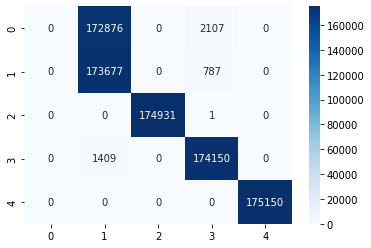

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, shuffle = True)

metrics_list_bytes = []
model_labels=[]

my_models = Model()
# accuracy, precision, recall, fscore, fpr = my_models.decisionTree(X_train, y_train, X_test, y_test)
model_labels.append('DT')
cm = my_models.decisionTree(X_train, y_train, X_test, y_test)
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')



KNearestClassifier
Accuracy: 0.9958735578593239
precision_recall_fscore_support: 0.9958731195162469
recall: 0.9958735578593239
fscore: 0.9958731518279375
FPR 0.0010316104047073875


<AxesSubplot:>

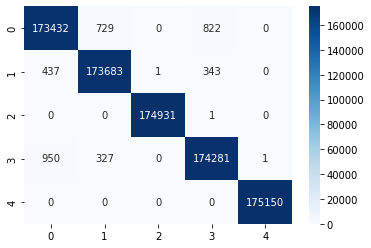

In [13]:
model_labels.append('KNN')
cm = my_models.KNearestClassifier(X_train, y_train, X_test, y_test)
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')


NaiveBayes
0.9866813394767154
Accuracy: 0.9866813394767154
precision_recall_fscore_support: 0.9866982660220408
recall: 0.9866813394767154
fscore: 0.9866863811233848
FPR 0.003329394408262628


<AxesSubplot:>

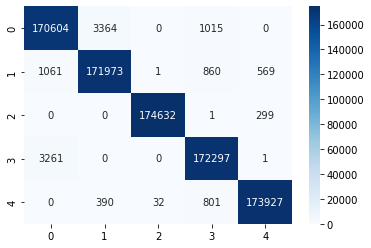

In [14]:
model_labels.append('NB')
cm = my_models.NaiveBayes(X_train, y_train, X_test, y_test)
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')

SGD
Accuracy: 0.9135972610754576
precision_recall_fscore_support: 0.9253292600777956
recall: 0.9135972610754576
fscore: 0.9087053270565155
FPR 0.02160481387971947


<AxesSubplot:>

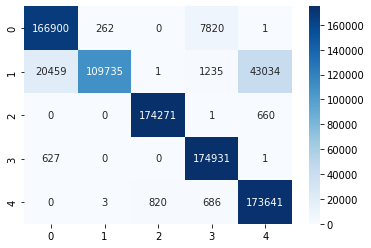

In [15]:
model_labels.append('SGD')
cm = my_models.SGD(X_train, y_train, X_test, y_test)
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')

Logistic Regression


C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9901255645146545
precision_recall_fscore_support: 0.9901228091590302
recall: 0.9901255645146545
fscore: 0.9901238455247554
FPR 0.0024686601456395544


<AxesSubplot:>

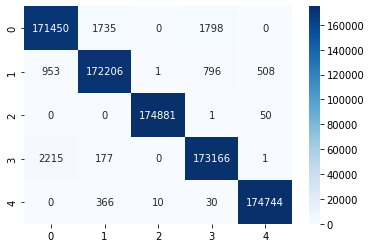

In [16]:
model_labels.append('LR')
cm = my_models.LogisticReg(X_train, y_train, X_test, y_test)
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')


RandomForest
Accuracy: 0.9780547784908489
precision_recall_fscore_support: 0.9784654820479103
recall: 0.9780547784908489
fscore: 0.9779844096925187
FPR 0.0054846644891741155


<AxesSubplot:>

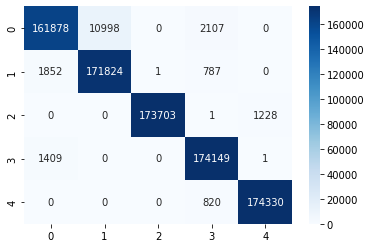

In [17]:

model_labels.append('RF')
cm = my_models.RandomForest(X_train, y_train, X_test, y_test)
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')

In [ ]:


model_labels.append('SVC')
#3metrics_list_bytes.append(my_models.SVClassifier(X_train, y_train, X_test, y_test))

In [12]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [13]:

from imblearn.over_sampling import SMOTE, RandomOverSampler

print("Before oversampling",  X.shape, dummy_y.shape)
        
#oversample = RandomOverSampler(sampling_strategy="not majority")  #SMOTE()       
#X, Y = oversample.fit_resample(X, dummy_y)

sm = SMOTE()
X, Y = sm.fit_resample(X, dummy_y)
        
print("After oversampling",  X.shape, Y.shape)

Before oversampling (3500350, 2) (3500350, 5)
After oversampling (3500350, 2) (3500350, 5)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, random_state = 0, shuffle=True) #use Y or dummy_y
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2625262, 2)
(2625262, 5)
(875088, 2)
(875088, 5)


In [15]:
def baseline_model():
    model = Sequential()
    model.add(Dense(40, input_shape = (2,), activation = "relu"))
    model.add(Dense(20, activation = "relu"))
    model.add(Dropout(0.2))

    model.add(Dense(5, activation = "softmax"))
    model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ["accuracy"])
    return model

In [ ]:
model = baseline_model()
history = model.fit(X_train, y_train, validation_split= 0.1, verbose=1, epochs=100)

Epoch 1/100


C:\Users\Razaq\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


73836/73836 [==============================] - 78s 1ms/step - loss: 0.0689 - accuracy: 0.9795 - val_loss: 0.0313 - val_accuracy: 0.9907
Epoch 2/100
73836/73836 [==============================] - 74s 1ms/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 0.0268 - val_accuracy: 0.9925
Epoch 3/100
73836/73836 [==============================] - 75s 1ms/step - loss: 0.0385 - accuracy: 0.9888 - val_loss: 0.0316 - val_accuracy: 0.9905
Epoch 4/100
73793/73836 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9896

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
type(y_pred)

In [ ]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm

In [ ]:
sns.heatmap(cm,annot=True, cmap='Blues', fmt='g')

In [ ]:
#estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
#kfold = KFold(n_splits=10, shuffle=True)
#results = cross_val_score(estimator, X, dummy_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))